In [1]:
import torch
import pickle

import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [2]:
TEST_CTC_DATASET_PATH = './test_data.pt'
VOCAB_PKL_PATH = './vocab.pkl'

In [3]:
dataset = torch.load(TEST_CTC_DATASET_PATH)
with open(VOCAB_PKL_PATH, 'rb') as fin:
    vocab_dict = pickle.load(fin)

# Часть 1. Метрики.

In [4]:
from metrics import (
    normalize_text,
    cer,
    wer,
    relative_cer,
    oracle_relative_cer,
    relative_wer,
    oracle_relative_wer,
)

In [5]:
# Тесты для проверки правильности реализации cer/wer 
assert(cer(normalize_text("алёнка родила девчёнку"), normalize_text("аленка радила девченку Инну")) == 6)
assert(wer(normalize_text("алёнка родила девчёнку"), normalize_text("аленка радила девченку Инну")) == 2)

assert(cer(normalize_text(""), normalize_text("")) == 0)
assert(wer(normalize_text(""), normalize_text("")) == 0)

assert(cer(normalize_text("Ростов-на-дону"), normalize_text("ростов на дону")) == 0)
assert(wer(normalize_text("Ростов-на-дону"), normalize_text("ростов на дону")) == 0)

assert(cer(normalize_text("It's"), normalize_text("it s")) == 0)
assert(wer(normalize_text("It's"), normalize_text("it s")) == 0)

# Часть 2. CTC декодинг.

In [6]:
from ctc_decoder import CTCDecoder
ctc_decoder = CTCDecoder(vocab_dict)

## <font color='red'>Внимание!</font> Далее ВЕЗДЕ используем только relative версии рассчета CER / WER и их oracle версии.

### Argmax декодинг.

In [8]:
# Рассчитаем усредненный по всему датасету relative CER / WER для ARGMAX варианта декодирования
cer_argmax = 0
wer_argmax = 0

for logits, ground_truth in dataset.values(): 
    predicted = ctc_decoder.argmax_decode(logits[0])
    ground_truth = normalize_text(ground_truth)
    predicted = normalize_text(predicted)
    
    cer_argmax += relative_cer(ground_truth, predicted)
    wer_argmax += relative_wer(ground_truth, predicted)
    
cer_argmax /= len(dataset)
wer_argmax /= len(dataset)

print(f"Mean CER in argmax decoding : {cer_argmax}")
print(f"Mean WER in argmax decoding : {wer_argmax}")

Mean CER in argmax decoding : 0.013932123056240395
Mean WER in argmax decoding : 0.1557061410929387


## Вопрос №1: Как соотносятся WER и CER в задаче ASR?

## Ответ: 
### - WER больше, видимо из-за того что символов в строке больше чем слов, т.е. ошибка "длины 1" в каждом слове не сильно увеличит CER, т.к. много правильных символов, но сильно увеличит WER т.к. правильных слов нет вовсе

In [9]:
# Рассчитаем усредненный по всему датасету relative CER / WER для BEAM_SEARCH варианта декодирования
# Для рассчета используем beam_size = 1 !!!
# Hint : стоит использовать mpire для ускорения
cer_bs1 = 0
wer_bs1 = 0

for logits, ground_truth in tqdm(dataset.values()): 
    predicted = ctc_decoder.beam_search_decode(logits[0], 1)[0]
    
    ground_truth = normalize_text(ground_truth)
    predicted = normalize_text(predicted)
    
    cer_bs1 += relative_cer(ground_truth, predicted)
    wer_bs1 += relative_wer(ground_truth, predicted)
    
cer_bs1 /= len(dataset)
wer_bs1 /= len(dataset)

print(f"CER in bs decoding : {cer_bs1}")
print(f"WER in bs decoding : {wer_bs1}")

  0%|          | 0/9630 [00:00<?, ?it/s]

CER in bs decoding : 0.01391897484184464
WER in bs decoding : 0.15568935967428724


In [10]:
# Проверим, что мы нигде не ошиблись в написании кода beam_search_decode
np.testing.assert_almost_equal(cer_argmax, cer_bs1, decimal=4)
np.testing.assert_almost_equal(wer_argmax, wer_bs1, decimal=4)

In [11]:
# graph_results получаются после исполнения process_dataset.py

In [13]:
import pandas as pd
graph_results = pd.read_csv("graph_results.csv")
beam_sizes = [4, 8, 16, 32]

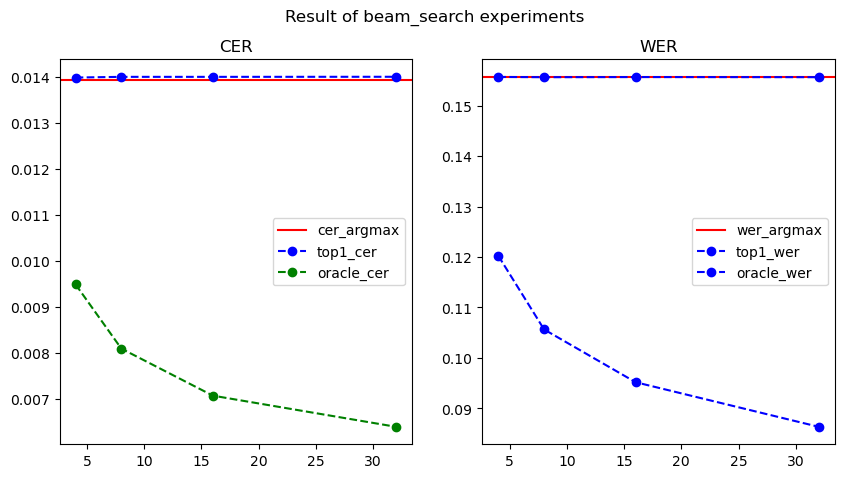

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Result of beam_search experiments')

axs[0].axhline(y = cer_argmax, color = 'r', linestyle = '-', label='cer_argmax')
axs[0].plot(beam_sizes, graph_results['top1_cer'], '--bo', label='top1_cer') 
axs[0].plot(beam_sizes, graph_results['oracle_cer'], '--go', label='oracle_cer')
axs[0].set_title('CER')
axs[0].legend()

axs[1].axhline(y = wer_argmax, color = 'r', linestyle = '-', label='wer_argmax')
axs[1].plot(beam_sizes, graph_results['top1_wer'], '--bo', label='top1_wer')
axs[1].plot(beam_sizes, graph_results['oracle_wer'], '--bo', label='oracle_wer')
axs[1].set_title('WER')
axs[1].legend()

## Вопрос №2: 
## - Сделайте выводы относительно поведения CER / WER при увеличении размера beam_size? 
## - Как соотносятся значения relative CER / WER и ORACLE варианты в beam_search ? 
## - Почему они так соотносятся ? 
## - Как можно улучшить beam search ?

## Ответ: 
### - CER / WER порой уменьшаются, но в 4 порядке, т.е. самый вероятный бим отличается от argmax в лучшую сторону, но не сильно
### - Oracle падает, т.к. в биме находится все больше гипотез и среди них содержится более хорошая, но Relative для top 1 хоть и отличается от argmax, но очень слабо 
### - 
### - думаю можно добавить семплирование, т.е. где брали topk будем брать k семплов